# Predicting Pokemon Types from Images and Statistics

Scott Ratchford

In [124]:
# Set paths to data files and directories

import os
import pandas as pd
import numpy as np

DATA_PATH = os.path.join(os.getcwd(), "data")
PKMN_STATS_PATH = os.path.join(DATA_PATH, "pokemon_stats.csv")
IGNORED_PKMN_PATH = os.path.join(DATA_PATH, "ignored_pokemon.csv")
IMAGES_DIR_PATH = os.path.join(DATA_PATH, "pokemon_images")

RNG_SEED = 151

TEST_SIZE = 0.2

In [125]:
# Import in-game statistics dataset
pkmn_stats = pd.read_csv(PKMN_STATS_PATH, encoding="utf-8")
print(f"PKMN: {pkmn_stats.shape[0]}")
print(f"PKMN Stats: {list(pkmn_stats.columns)}")

# Drop rows that contain Pokemon to be ignored
ignored_pkmn = pd.read_csv(IGNORED_PKMN_PATH, encoding="utf-8", delimiter="\t")
ignored_pkmn = ignored_pkmn.dropna(axis=0, subset=["Number"])
print(f"Ignored PKMN: {ignored_pkmn["Name"].tolist()}")

pkmn_stats = pkmn_stats[~pkmn_stats["Number"].isin(ignored_pkmn["Number"])]
print(f"PKMN after dropping ignored: {pkmn_stats.shape[0]}")


PKMN: 1023
PKMN Stats: ['Number', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary']
Ignored PKMN: ['Giratina', 'Darmanitan', 'Hoopa']
PKMN after dropping ignored: 1022


In [126]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = pkmn_stats.copy()

# Drop columns that provide too much information about the Pokemon
tmi_cols = ["Name", "Generation"]
X = X.drop(labels=tmi_cols, axis=1)

# Drop other columns
drop_cols = ["Type 2", ]
X = X.drop(labels=drop_cols, axis=1)

# Drop columns containing target information
target_cols = ["Type 1", ]
y = pkmn_stats[target_cols].copy()
X = X.drop(labels=target_cols, axis=1)

# Encode type strings (to ints)
type_label_encoder = LabelEncoder()
y["Type 1"] = type_label_encoder.fit_transform(y["Type 1"])
y["Type 1"] = y["Type 1"].astype(dtype=int)
# y_train["Type 2"] = type_label_encoder.fit_transform(y_train["Type 2"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RNG_SEED)

In [127]:
# Create the KNN model for in-game statistics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_stats_model = KNeighborsClassifier()
# hyperparameters to try
knn_hyperparameters = {
    "n_neighbors": range(3, 11),
    "leaf_size": range(10, 41),
    "p": range(1, 4),
    "weights": ("distance", "uniform", ),
    "algorithm": ("kd_tree", "ball_tree", ),
}

knn_clf = GridSearchCV(knn_stats_model, knn_hyperparameters, n_jobs=-1)

knn_stats_model = knn_clf.fit(X_train, y_train.values.ravel())

In [128]:
from sklearn.metrics import accuracy_score, confusion_matrix

knn_pred = knn_clf.predict(X_test)

accuracy = accuracy_score(y_test, knn_pred)
conf_matrix = confusion_matrix(y_test, knn_pred)
print(f"Accuracy: {accuracy}, Test Error: {1-accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.09268292682926829, Test Error: 0.9073170731707317
Confusion Matrix:
[[5 2 0 0 0 0 2 0 0 2 0 0 3 3 0 0 2 3]
 [0 0 0 1 0 2 1 0 0 0 1 0 1 0 0 0 0 1]
 [1 1 1 0 1 0 1 0 0 2 0 0 0 1 0 0 1 2]
 [2 1 0 0 0 3 2 1 0 1 0 0 1 0 0 0 0 4]
 [0 0 0 0 1 0 1 0 1 3 0 0 3 0 1 0 1 1]
 [1 0 0 0 1 0 0 0 0 1 1 0 3 1 0 0 0 0]
 [0 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 3]
 [0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 2 0 1 2]
 [1 1 1 0 0 0 3 0 0 1 2 0 1 0 1 1 0 7]
 [2 0 0 0 0 2 0 0 0 1 1 1 1 0 0 1 1 0]
 [1 1 2 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1]
 [3 3 1 0 0 0 0 0 0 4 2 0 2 3 0 0 0 2]
 [1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 2]
 [0 2 1 1 0 0 1 0 2 2 0 1 1 0 3 1 0 1]
 [0 1 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1]
 [0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 2 0]
 [0 0 0 0 1 0 1 1 0 3 0 0 1 2 2 2 1 1]]


In [129]:
# Match test data with original data to find names and types
pkmn_stats.reset_index()
knn_pred_df = pd.DataFrame(knn_pred, columns=["Type 1 Prediction"])
knn_pred_df["Type 1 Prediction"] = type_label_encoder.inverse_transform(knn_pred_df["Type 1 Prediction"])
knn_pred_df.reset_index()

# join knn pred with X_test on index
x_test_and_knn_pred = pd.merge(X_test, knn_pred_df, how="inner", left_index=True, right_index=True, validate="1:1")
# join that result to pkmn_stats to find predicted type
join_on = ["Number", "Total", "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed", "Legendary"]
rejoined_data = pd.merge(pkmn_stats, x_test_and_knn_pred, how="inner", left_on=join_on, right_on=join_on, validate="1:1")

## Images

In [130]:
import os

IMG_TEST_DIR = os.path.join(os.getcwd(), "data", "pokemon_images", "test")
IMG_TRAIN_DIR = os.path.join(os.getcwd(), "data", "pokemon_images", "train")

PKMN_COLORS_PATH = os.path.join(os.getcwd(), "pokemon_colors.csv")

In [131]:
import os
import pandas as pd
from PIL import Image
import webcolors
from webcolors._definitions import _get_hex_to_name_map
from collections import Counter
from typing import Tuple

  
CSS2_COLOR_DICT = _get_hex_to_name_map("css2")
CSS2_COLOR_NAMES = list(CSS2_COLOR_DICT.values())

def closest_color(requested_color: Tuple[int, int, int]) -> str:
    """
    Given an RGB tuple, find the closest CSS2 color name based on Euclidean distance.
    
    Parameters:
        requested_color (Tuple[int, int, int]): The RGB color tuple.
        
    Returns:
        str: The name of the closest CSS2 color.
    """
    min_distance = float('inf')
    closest_name = None
    for hex, name in CSS2_COLOR_DICT.items():
        rgb = webcolors.hex_to_rgb(hex)
        distance = sum((comp1 - comp2) ** 2 for comp1, comp2 in zip(requested_color, rgb))
        if distance < min_distance:
            min_distance = distance
            closest_name = name
    
    return closest_name

def get_css2_color_name(rgb_tuple: Tuple[int, int, int]) -> str:
    """
    Convert an RGB tuple to its CSS2 color name.
    If an exact match is not found, use the closest matching color.
    
    Parameters:
        rgb_tuple (Tuple[int, int, int]): The RGB color tuple.
        
    Returns:
        str: The CSS2 color name.
    """
    try:
        # Attempt to get the CSS2 color name directly.
        color_name = webcolors.rgb_to_name(rgb_tuple, "css2")
    except ValueError:
        # If there's no exact match, use the closest matching color.
        color_name = closest_color(rgb_tuple)
    
    return color_name

def image_color_breakdown(image_path: str) -> pd.DataFrame:
    """
    Given the path to a PNG image, compute the percentage breakdown
    of the CSS2 colors present in the image.
    Transparent pixels (alpha == 0) are ignored.
    
    Parameters:
        image_path (str): The path to the PNG image.
        
    Returns:
        pd.DataFrame: A DataFrame with columns:
                      ['filename', 'aqua', 'black', 'blue', 'fuchsia', 'green', 'gray',
                       'lime', 'maroon', 'navy', 'olive', 'purple', 'red', 'silver',
                       'teal', 'white', 'yellow'].
    """
    # Open the image in RGBA mode to handle transparency.
    img = Image.open(image_path).convert('RGBA')
    # Filter out pixels where the alpha channel is 0 (fully transparent).
    pixels = [pixel for pixel in img.getdata() if pixel[3] != 0]
    
    if not pixels:
        raise ValueError("No non-transparent pixels found in the image.")
    
    total_pixels = len(pixels)
    
    # Count the occurrences of each allowed color.
    color_counts = Counter()
    for pixel in pixels:
        rgb = pixel[:3]
        color_name = get_css2_color_name(rgb)
        color_counts[color_name] += 1
    
    # Prepare the breakdown dictionary with all allowed colors.
    breakdown = {'filename': os.path.basename(image_path)}
    for color in CSS2_COLOR_NAMES:
        breakdown[color] = 0.0  # default 0%
    
    # Compute the percentage for each color that occurred.
    for color, count in color_counts.items():
        breakdown[color] = (count / total_pixels) * 100
    
    # Create the DataFrame with the columns in the required order.
    columns = [
        'filename', 'aqua', 'black', 'blue', 'fuchsia', 'green', 'gray',
        'lime', 'maroon', 'navy', 'olive', 'purple', 'red', 'silver',
        'teal', 'white', 'yellow'
    ]
    df = pd.DataFrame([breakdown], columns=columns)
    
    return df


In [132]:
import webcolors
import PIL
import os
import pandas as pd

pkmn_img_colors = pd.read_csv(PKMN_COLORS_PATH, index_col=0)

# # Create a dataframe of all test images
# pkmn_img_colors = pd.DataFrame()

# img_filenames = []

# for pkmn_name in os.listdir(IMG_TEST_DIR):
#     pkmn_folder = os.path.join(IMG_TEST_DIR, pkmn_name)
#     if os.path.isdir(pkmn_folder):  # Check if it's a directory
#         # Get all image files in the class folder
#         images = [os.path.join(pkmn_folder, img) for img in os.listdir(pkmn_folder) if img.endswith('.png')]
#         img_filenames.extend(images)
#         for filename in images:
#             temp_df = image_color_breakdown(filename)
#             temp_df['Name'] = pkmn_name  # Add pkmn_name in a column called "Name"
#             pkmn_img_colors = pd.concat([pkmn_img_colors, temp_df], ignore_index=True)
#
# pkmn_img_colors.to_csv(PKMN_COLORS_PATH, sep=",")



In [133]:
# Import in-game statistics dataset
pkmn_numbers = pd.read_csv(PKMN_STATS_PATH, encoding="utf-8")

# Drop rows that contain Pokemon to be ignored
ignored_pkmn = pd.read_csv(IGNORED_PKMN_PATH, encoding="utf-8", delimiter="\t")
ignored_pkmn = ignored_pkmn.dropna(axis=0, subset=["Number"])

pkmn_numbers = pkmn_numbers[~pkmn_numbers["Number"].isin(ignored_pkmn["Number"])]

pkmn_numbers = pkmn_numbers.drop(labels=['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'], axis=1)
pkmn_numbers["Name"] = pkmn_numbers["Name"].apply(lambda x: x.lower())

# Add numbers to image data
pkmn_img_data = pd.merge(pkmn_numbers, pkmn_img_colors, how="left", left_on=["Name", ], right_on=["Name", ])

pkmn_img_data = pkmn_img_data.dropna()

print(f"pkmn_img_data columns: {list(pkmn_img_data.columns)}")

pkmn_img_data columns: ['Number', 'Name', 'Type 1', 'Type 2', 'filename', 'aqua', 'black', 'blue', 'fuchsia', 'green', 'gray', 'lime', 'maroon', 'navy', 'olive', 'purple', 'red', 'silver', 'teal', 'white', 'yellow']


In [134]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X_colors = pkmn_img_data.copy()

# Drop columns that provide too much information about the Pokemon
tmi_color_cols = ["Name", "Number", "filename", ]
X_colors = X_colors.drop(labels=tmi_color_cols, axis=1)

# Drop other columns
drop_color_cols = ["Type 2", ]
X_colors = X_colors.drop(labels=drop_color_cols, axis=1)

# Drop columns containing target information
target_color_cols = ["Type 1", ]
y_colors = pkmn_img_data[target_cols].copy()
X_colors = X_colors.drop(labels=target_color_cols, axis=1)

# Encode type strings (to ints)
type_label_encoder = LabelEncoder()
y_colors["Type 1"] = type_label_encoder.fit_transform(y_colors["Type 1"])
y_colors["Type 1"] = y_colors["Type 1"].astype(dtype=int)

X_colors_train, X_colors_test, y_colors_train, y_colors_test = train_test_split(X_colors, y_colors, test_size=TEST_SIZE, random_state=RNG_SEED)

In [144]:
# Create the KNN model for colors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_colors_model = KNeighborsClassifier()
# hyperparameters to try
knn_hyperparameters = {
    "n_neighbors": range(15, 31),
    "leaf_size": range(10, 31),
    "p": range(1, 4),
    "weights": ("distance", ),  # "uniform", 
    "algorithm": ("kd_tree", ), # "ball_tree", 
    "metric": ("minkowski", "chebyshev", ),
}

knn_colors_clf = GridSearchCV(knn_colors_model, knn_hyperparameters, n_jobs=-1)
knn_colors_model = knn_colors_clf.fit(X_colors_train, y_colors_train.values.ravel())

print(knn_colors_clf.best_params_)

{'algorithm': 'kd_tree', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}


In [145]:
from sklearn.metrics import accuracy_score

knn_color_pred = knn_colors_clf.predict(X_colors_test)

accuracy = accuracy_score(y_colors_test, knn_color_pred)
print(f"Accuracy: {accuracy}, Test Error: {1-accuracy}")
print(f"{accuracy * y_colors_test.shape[0]:.0f} out of {y_colors_test.shape[0]} correctly predicted")

Accuracy: 0.5085714285714286, Test Error: 0.49142857142857144
712 out of 1400 correctly predicted


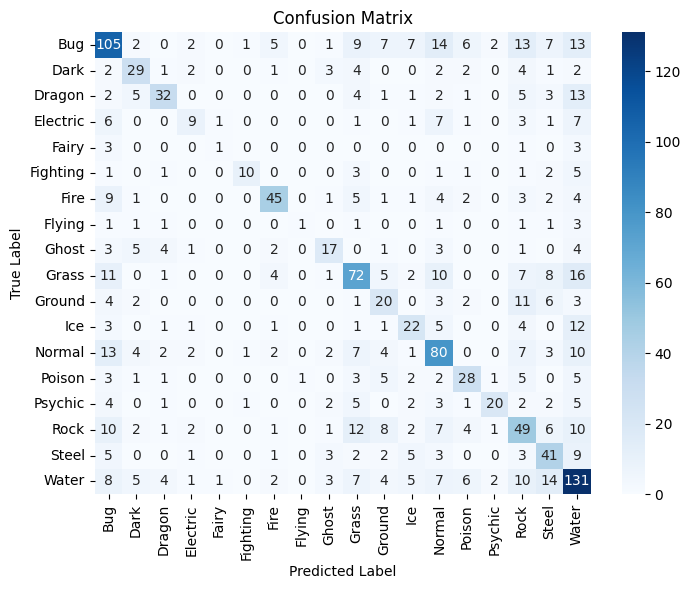

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_colors_test, knn_color_pred)

# Get the unique encoded labels from the true labels
labels_encoded = np.unique(y_colors_test)
# Use the previously defined and fitted type_label_encoder to decode labels
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap visualization with the decoded labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

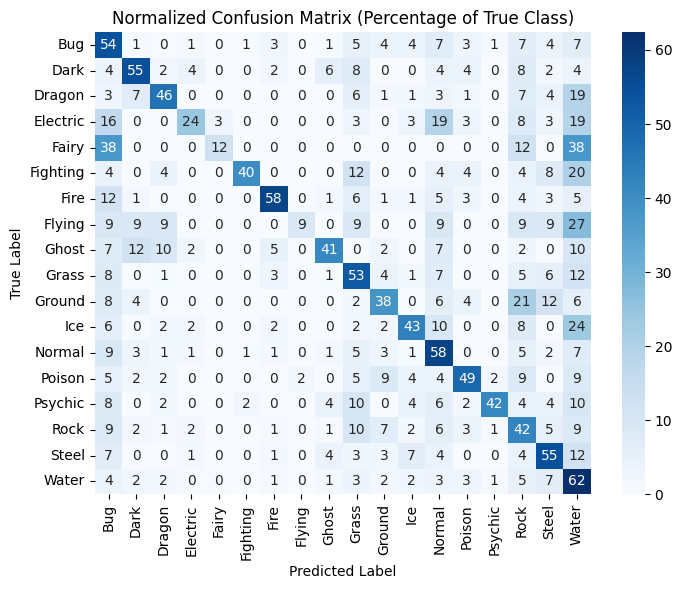

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_colors_test, knn_color_pred)

# Normalize the confusion matrix by the true labels (i.e. each row)
cm_normalized = cm.astype(int) / cm.sum(axis=1)[:, np.newaxis]

# Retrieve the original class labels using the fitted label encoder
labels_encoded = np.unique(y_colors_test)
labels = type_label_encoder.inverse_transform(labels_encoded)

# Create the heatmap using the normalized percentages (multiplied by 100)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized * 100, annot=True, fmt=".0f", cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Percentage of True Class)')
plt.show()

TODO: AI usage statement, ChatGPT helped write:
1. image color analysis functions
2. confusion matrix visualization